In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import numpy as np
from sklearn.model_selection import train_test_split

### Load the dataset

In [95]:
raw_train = pd.read_csv('Spanish_High_Speed_Rail_Ticket_Price.csv')
raw_train.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
1,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
2,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
3,2019-04-24 06:21:57,SEVILLA,MADRID,2019-05-03 08:35:00,2019-05-03 15:26:00,LD-MD,34.35,Turista con enlace,Promo +
4,2019-04-19 21:13:55,VALENCIA,MADRID,2019-05-10 09:40:00,2019-05-10 11:20:00,AVE,45.30,Turista,Promo


In [96]:
raw_train.shape

(25798, 9)

### Fill in missing values

In [97]:
raw_train.isna().sum()

insert_date       0
origin            0
destination       0
start_date        0
end_date          0
train_type        0
price          3082
train_class     103
fare            103
dtype: int64

In [98]:
price = raw_train['price'].mean()
train_class = raw_train['train_class'].mode()[0]
fare = raw_train['fare'].mode()[0]

print("Filling missing price value with {}".format(price))
print("Filling missing price value with {}".format(train_class))
print("Filling missing price value with {}".format(fare))

Filling missing price value with 63.44453248811638
Filling missing price value with Turista
Filling missing price value with Promo


In [0]:
train_df = raw_train.fillna({'price':price,'train_class':train_class,'fare':fare})

### Checking Price distribution

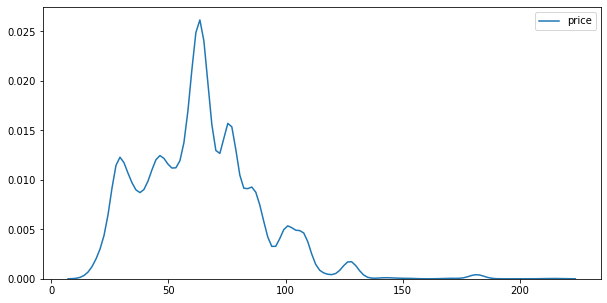

In [100]:
plt.figure(figsize=(10,5))
sns.kdeplot(train_df['price'])

### Bayesian analysis on Price 

In [101]:
train_df['price'].max(),train_df['price'].min(),train_df['price'].std()

(214.2, 16.6, 24.31529991873853)

In [102]:
# setting prior distribution for price. 
# assuming normal distribution as price is normally distributed as seen from the above graph
# setting mean value for prior distribution

with pm.Model() as model_price:
    # mean can be uniformaly distributed between lower and higher value
    mean = pm.Uniform('mean', lower=0, upper=300)     # assuming mean price will between 0 to 300

    # standard deviation can only be positive.     
    std = pm.HalfNormal('std', sd=10)

    # posterior distribution for price
    price = pm.Normal('price', mu=mean, sd=std, observed=train_df['price'].values)
    
    # mcmc sampling
    # To evaluate the convergence of MCMC chains it is helpful to create multiple chains that have different starting values
    # setting number of chains to 3
    trace_price = pm.sample(1000, tune=1300, chains=3)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [std, mean]
Sampling chain 2, 0 divergences: 100%|██████████| 2300/2300 [00:08<00:00, 271.52it/s]


### Trace Plot Diagnostics
Trace plots involve simulating two or more chains of parameter values and plotting the valuesof each chain against the sample number of the sampling process, typically on the same set of axes. If thechains are all representative of the posterior distribution, they should overlap each other and be unrelatedto their randomly set starting positions. They should also be stationary around the same modal value


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f971b8f0400>,
      dtype=object)

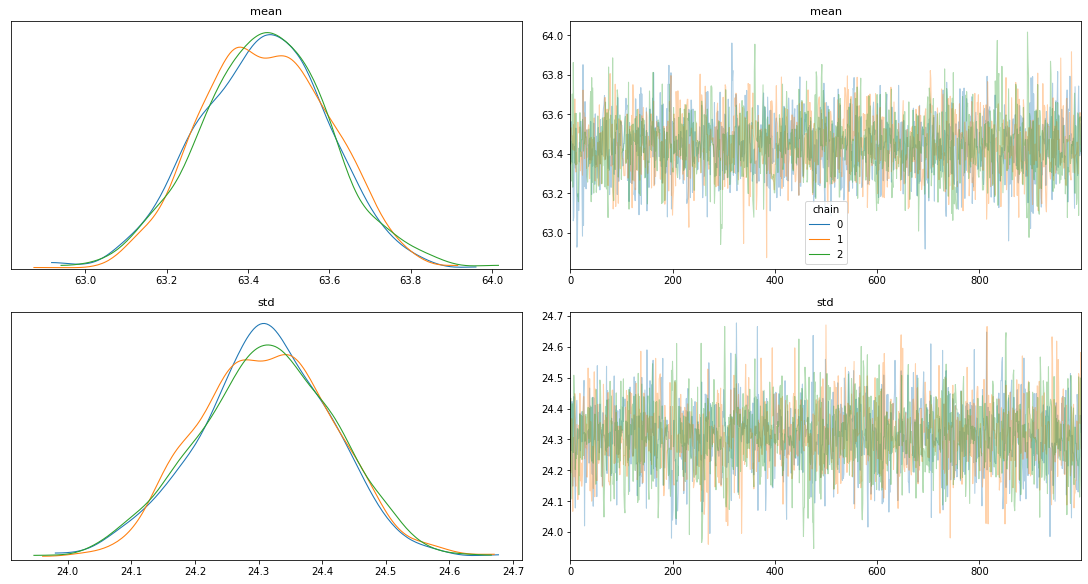

In [103]:
az.plot_trace(trace_price,legend=True,figsize=(15,8))

In [104]:
# Gelman Rubin test. Values close to 1.0 means convergence.
pm.rhat(trace_price)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mean     float64 0.9997
    std      float64 1.001

In [105]:
az.summary(trace_price)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,63.441,0.156,63.144,63.724,0.003,0.002,2482.0,2482.0,2465.0,1676.0,1.0
std,24.311,0.110,24.102,24.508,0.002,0.001,2843.0,2843.0,2845.0,2109.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f971b4de588>,
      dtype=object)

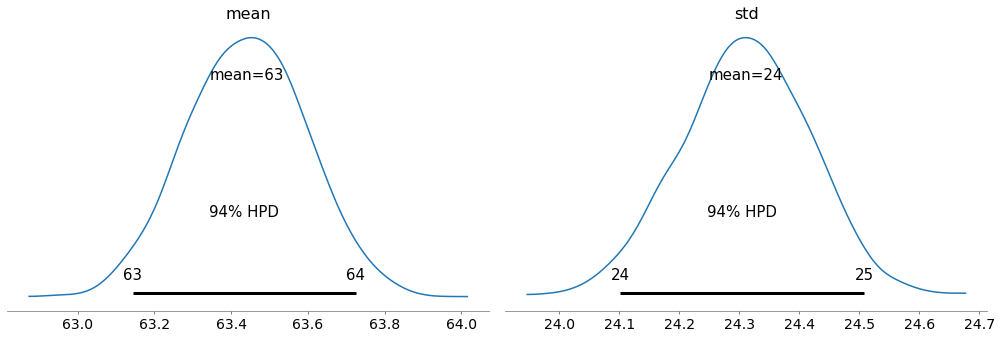

In [106]:
az.plot_posterior(trace_price)

### Posterior Predictive Checks

In [107]:
# PPC analyze the degree to which data generated from the model deviate from data generated from the true distribution
ppc = pm.sample_posterior_predictive(trace_price, model=model_price)
np.asarray(ppc['price']).shape

100%|██████████| 3000/3000 [00:07<00:00, 413.78it/s]


(3000, 25798)

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'mean(price)'),
 Text(0.5, 1.0, 'Posterior predictive of the mean')]

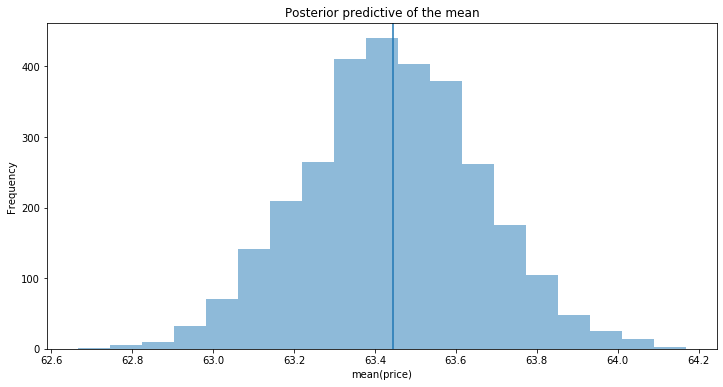

In [108]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([price.mean() for price in ppc['price']], bins=19, alpha=0.5)
ax.axvline(train_df['price'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(price)', ylabel='Frequency')